<center><h1>  </h1></center>
<center><h1> IFT-6758  </h1></center>
<center><h1> Science des données</h1></center>
<center><h2> Automne - 2023 </h2></center>
<center><h3> Devoir 7 </h3></center>
<center><h3> </h3></center>

Date limite :  **Le 14 déc, 23h59 HAE** sur [Gradescope](https://www.gradescope.ca/courses/11400/assignments/67115/) sous forme de .ipynb

Total de points = 50

**N'IMPORTEZ RIEN D'AUTRE DES BIBLIOTHÈQUES DE CEUX-CI DONNÉES**

Ceci est important pour exécuter votre code!

In [41]:
#@title Importations (Exécuter d'abord cette cellule) { run: "auto" }

!pip install datasets

# imports here

import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from datasets import load_dataset

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#Configuring the plot size
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Remarque**:

Nous utiliserons la bibliothèque Keras: [https://keras.io/about/](https://keras.io/about/) pour diverses fonctions, et elle utilise le backend Tensorflow par défaut.
Veuillez vous assurer d'utiliser Tensorflow `2.0` ou supérieur si vous exécutez ce notebook localement.
Sur Google Colab, il est par défaut `2.14.0` normalement et vous ne devriez pas avoir de problème.

## Sommaire

Ce devoir vise à utiliser quelques idées fondamentales en modélisation de séries chronologiques en Python, démontrant comment appliquer ces modèles à des données du monde réel.

Il y a 5 tâches au total comprenant des questions sous chacune d'elles.


* Tâches 1, 2, 3 : Vous n'avez qu'à remplir le code manquant marqué comme `#Student TODO`
* Les tâches 4 et 5 sont exactement identiques et nécessitent d'appeler les fonctions implémentées pour deux jeux de données différents avec des configurations appropriées dans un objet de dictionnaire, de visualiser les résultats et de les interpréter.


--------

- Veuillez vous assurer d'exécuter les cellules dans l'ordre, car les fonctions et les variables utilisées pourraient provenir des cellules précédentes.
- Avant la soumission, veuillez exécuter toutes les cellules dans l'ordre (de haut en bas) et conserver les sorties.



Dans la prévision de séries chronologiques ci-dessous, nous allons entraîner trois types de modèles :

1. **Modèles linéaires**: Ces modèles supposent une relation linéaire entre les données de séries chronologiques et les prédicteurs.

2. **Modèles autorégressifs linéaires**: Ces modèles prolongent les modèles linéaires en intégrant les valeurs passées de la série chronologique comme prédicteurs. Cette approche est particulièrement efficace pour capturer la 'mémoire' de la série chronologique.

3. **Modèle autorégressif non linéaire** (p-ième ordre) : Ces modèles sont un pas en avant, permettant de modéliser des relations plus complexes et non linéaires dans les données. Le 'p-ième ordre' fait référence au nombre d'observations décalées utilisées en entrée.

#Fonctions d'aide au prétraitement des données

**Préparation des données : fonctions d'aide**

Avant de se lancer dans la construction de modèles, il est essentiel de prétraiter les données. Un prétraitement adapté permet d'améliorer considérablement les performances et la précision du modèle.

Explorons les étapes de prétraitement mises en œuvre dans le code ci-dessous:

1. **`standardize_features`**:
   - Cette fonction normalise les caractéristiques d'un ensemble de données.
   - Elle prend un tableau NumPy `X` où les lignes représentent des échantillons et les colonnes représentent des caractéristiques. La fonction normalise chaque caractéristique en soustrayant sa moyenne, puis en la divisant par son écart-type. Ce processus garantit que chaque caractéristique a une moyenne de 0 et un écart-type de 1, ce qui est une exigence courante pour de nombreux algorithmes d'apprentissage automatique.
   - Elle retourne l'ensemble de données normalisé.

2. **`preprocess_dataset`**:
   - Cette fonction prétraite un ensemble de données chronologiques pour le préparer à des tâches de prédiction.
   - Processus :
     - Elle localise d'abord la colonne cible dans le cadre de données `df`.
     - Convertit le cadre de données en tableau NumPy et applique quelques étapes de prétraitement, telles que le remplissage des valeurs NaN et la suppression de certaines colonnes en fonction de critères spécifiques (par exemple, trop de zéros ou de NaNs).
     - La colonne cible est ensuite isolée et la fonction `standardiser_features` est appliquée à cette colonne.
   - Elle retourne l'ensemble de données prétraitées et normalisées prêtes à être utilisées dans la modélisation de séries chronologiques.

3. **`prepare_dataloaders`**:
   - Cette fonction prépare des chargeurs de données pour l'entraînement, la validation et les tests d'un modèle utilisant des données chronologiques.
   - Processus :
     - Elle crée d'abord des séquences cible en faisant rouler le tableau `data`.
     - Les données sont ensuite divisées en ensembles d'entraînement, de validation et de test.
     - Pour chacun de ces ensembles, un `TimeseriesGenerator` est créé, qui est un utilitaire de Keras utilisé pour transformer automatiquement une séquence en lots de données temporelles.
     - La fonction prend des paramètres supplémentaires à partir de `kwargs` comme `window_size` et `batch_size` pour déterminer la taille des séquences d'entrée et de sortie et le nombre d'échantillons par lot.
   - Elle retourne trois objets `TimeseriesGenerator` pour l'entraînement, la validation et les tests. Ceux-ci sont utilisés pour alimenter les données dans les modèles dans un format adapté à la prévision de séries chronologiques.

In [3]:
def standardize_features(X):
    """
    X: array of shape (num_samples, num_features)
    """
    X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
    return X


def preprocess_dataset(df, target, lookback=1, offset=1, drop_features=[]):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, rows are samples (timesteps)
        columns are features. target is index of the target feature
        lookback: Size of window for prediction. Default=1, aka. only using the x_{t-1} to predict x_t
    """
    target = df.columns.get_loc(target) - offset #Offset to locate the correct target column
    np_data = np.asarray(df)[:, offset:].astype(np.float32)
    drop_cols = np.where(np.isnan(np_data).sum(0) == len(np_data))[0] + 1
    np_data = np.nan_to_num(np_data, nan=1e-8)
    drop_cols = np.unique(np.concatenate( ([0, target], drop_cols, np.where((np_data == 0).sum(0) == len(np_data))[0] + 1) ))
    keep_cols = np.setdiff1d(np.arange(np_data.shape[1]), drop_cols)
    np_data = np_data[:, target] # keep_cols
    dataset = standardize_features(np_data)
    print(dataset.shape, dataset.mean(0), dataset.std(0))
    return dataset

def prepare_dataloaders(data, kwargs):

    # window data
    targets = np.roll(data, shift=1, axis=0)
    targets[-1] = 0

    # Assuming 'data' and 'targets' are your input and target sequences
    train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, shuffle=False, random_state=42)
    train_data, val_data, train_targets, val_targets = train_test_split(train_data, train_targets, test_size=0.1, shuffle=False, random_state=42)

    # Create TimeseriesGenerators for training, validation, and test sets
    train_generator = TimeseriesGenerator(train_data, train_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])
    val_generator = TimeseriesGenerator(val_data, val_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])
    test_generator = TimeseriesGenerator(test_data, test_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])

    return train_generator, val_generator, test_generator


## ✅ **Tâche 1 : Créer des baselines**

Nous allons maintenant implémenter des classes pour les baselines qui produisent soit la dernière valeur soit la moyenne en fonction du type de baseline. Ce modèle ne sera pas entraîné ni optimisé car il n'a pas de paramètres réels, il nous fournit simplement une limite inférieure de la performance que nous pouvons obtenir.

[2 points]

### 📌 Q1.1 Baseline Mean: Implementation

Voici la traduction de la section :

`BaselineMean` produit la moyenne de la série $x$ comme prédiction.

Complétez la méthode `predict()` pour y parvenir.

In [4]:
class BaselineMean(object):
    def __init__(self):
        super(BaselineMean, self).__init__()

    def predict(self, x):
        """
        (x_{t-1}, *) -> (x_t, *)
        """
        if x.ndim == 1:
            x = np.reshape(x, (x.shape[0], 1))

        ### Student TODO START###

        # Calculer la moyenne de la série
        valeur_moyenne = np.mean(x, axis=0)

        # Créer un tableau de sortie avec la même forme que l'entrée rempli de la valeur moyenne
        out = np.full_like(x, valeur_moyenne)

        ### Student TODO END###
        return out

[2 points]

### 📌 Q1.2 Baseline Last: Implementation


`BaselineLast` ne produit que la dernière valeur $x_{t-1}$ de la série $x$.

Complétez la méthode `predict()` pour y parvenir.

In [5]:
class BaselineLast(object):
    def __init__(self):
        super(BaselineLast, self).__init__()

    def predict(self, x):
        """
        (x_{t-1}, *) -> (x_t, *)
        """
        if x.ndim == 1:
            x = np.reshape(x, (x.shape[0], 1))

        ### Student TODO START###

        # Prendre la dernière valeur de x
        derniere_valeur = x[-1]

        # Créer un tableau de sortie rempli avec la dernière valeur de x
        out = np.full((x.shape[0], x.shape[1]), derniere_valeur)

        ### Student TODO END###

        return out

## ✅ **Tâche 2 : Créer un modèle autorégressif linéaire**



Remarquez que nos modèles de base ne tiennent pas compte des entrées précédentes ('mémoire') pour faire des prévisions sur l'avenir. Ils ne sont pas autorégressifs.

Maintenant, créons deux modèles autorégressifs (AR) différents qui font des prédictions en fonction des entrées passées. Le premier modèle sera un modèle linéaire et le second sera un modèle non linéaire qui est un réseau MLP avec une non-linéarité ReLU dans sa seule couche cachée.

Votre tâche consiste à configurer les couches de ces modèles pour les prévisions à l'aide de la bibliothèque Keras.

Le paramètre `kwargs` fait référence à des arguments de mot-clé qui sont un dictionnaire avec toutes les valeurs nécessaires pour configurer et entraîner les modèles.
Supposez que vous ayez accès à la taille de la fenêtre de la série chronologique d'entrée en utilisant la clé `window_size` du dictionnaire `kwargs` et à la taille cachée de l'MLP en utilisant la clé `mlp_dim`.

[4 points]

### 📌 Q2.1 Définir le modèle autorégressif linéaire



Ajoutez les couches du modèle linéaire dans Keras. Consultez le [lien](https://keras.io/guides/sequential_model/)

In [6]:
def ar_linear(kwargs):
    model = None
    #Student TODO START

    window_size = kwargs.get('window_size', 1)
    model = Sequential()
    # Couche cachée avec la fonction d'activation lineaire
    model.add(Dense(units=1, input_dim=window_size, activation='linear'))

    #Student TODO END
    return model

[4 points]

### 📌 Q2.3 Définir le modèle autorégressif MLP (nonlinéaire)



Ajoutez les couches cachée et de sortie du modèle MLP dans Keras. Consultez le [lien](https://keras.io/guides/sequential_model/) :
* Il n'y a qu'une seule couche cachée et elle utilise une non-linéarité ReLU.
* La taille de la couche cachée peut être déduite de la valeur `mlp_dim` du dictionnaire `kwargs`.
* La couche de sortie est la prédiction du modèle.

In [7]:
def ar_mlp(kwargs):
    model = None
    hidden_size = kwargs['mlp_dim']

    #Student TODO START
    window_size = kwargs.get('window_size', 1)
    model = Sequential()

    # Couche cachée avec la fonction d'activation ReLU
    model.add(Dense(units=hidden_size, input_dim=window_size, activation='relu'))


    # Couche de sortie pour effectuer la prédiction
    model.add(Dense(units=1, activation='linear'))


    #Student TODO END
    return model

### Fonctions d'aide aux modèles


In [8]:
# helper functions
def create_baseline_model(kwargs):
    if kwargs['model_name'] == 'baseline-mean':
        model = BaselineMean()
    elif kwargs['model_name'] == 'baseline-last':
        model = BaselineLast()
    return model

def create_ar_model(kwargs):
    if kwargs['model_name'] == 'ar-linear':
        model = ar_linear(kwargs)
    elif kwargs['model_name'] == 'ar-mlp':
        model = ar_mlp(kwargs)
    else:
        raise NotImplementedError
    return model

def create_model(kwargs):
    if 'baseline' in kwargs['model_name']:
        return create_baseline_model(kwargs)
    else:
        return create_ar_model(kwargs)

## 📌 🥇 (Bonus) Définir des modèles pour le cas spécial (MA) avec ARIMA

*[4 points]

Le modèle ARIMA pourrait être utilisé pour adapter un modèle de Moyenne Mobile (MA) : (voir https://otexts.com/fpp2/MA.html) $\varepsilon_t = \sum_{j=0}^\infty (-\theta)^j y_{t-j}.$

Écrivez le code pour ajuster un tel modèle.


In [60]:
from statsmodels.tsa.arima.model import ARIMA

#STUDENT TODO OPTIONAL
def fit_arima_model(data, p, d, q):
    model = ARIMA(data, order=(p,d,q))
    model_fit = model.fit()
    return model_fit

# p est le nombre de termes autorégressifs
# d est le nombre de différences non saisonnières nécessaires pour obtenir une série stationnaire
# q est le nombre de termes d'erreurs de prévision retardés dans l'équation de prédiction (termes de moyenne mobile)

# Métriques d'évaluation

Nous utiliserons les métriques suivantes:

* Erreur absolue moyenne (MAE)
* Erreur quadratique moyenne (MSE)

# Fonctions d'aide à l'entraînement et à l'évaluation

## ✅ **Tâche 3 : Définir la fonction pour l'entraînement et l'évaluation**

[12 points]

### 📌 Q3. Complétez la fonction `hyperparameter_sweep` pour l'entraînement et l'optimisation des hyperparamètres :

Référez-vous à la documentation Keras appropriée dans le lien link: [https://keras.io/api/models/model_training_apis/](https://keras.io/api/models/model_training_apis/).

* Pour l'entraînement du modèle, utilisez l'optimiseur Adam et la perte MSE avec `model.compile`.
* Utilisez `model.evaluate` sur le `val_generator` pour obtenir les métriques de validation.
* Gardez une trace des résultats de toutes les configurations et renvoyez la `best_mse` et la `best_window_size`.

In [10]:
def hyperparameter_sweep(df, cfg):

    # Perform hyperparameter sweep for window_size
    best_mse = float('inf')
    best_window_size = None

    for window_size in cfg['hp_values']:
        cfg[cfg['hp_name']] = window_size
        data = preprocess_dataset(df, cfg['target'], lookback=cfg['window_size'])
        train_generator, val_generator, test_generator = prepare_dataloaders(data, cfg)
        model = None

        ### Student TODO START###
        def calculate_mse_for_baseline_model(model, generator):
          predictions = []
          actuals = []
          # Parcourir le générateur de validation pour obtenir les prédictions et les vraies valeurs
          for batch in generator:
              X, y_true = batch
              y_pred = model.predict(X)  # Prédictions du modèle de base

              # Étant donné que BaselineMean.predict renvoie un tableau avec la même forme que l'entrée,
              # nous prenons la première colonne pour correspondre aux vraies valeurs 1D
              y_pred = y_pred[:, 0] if y_pred.ndim > 1 else y_pred

              predictions.append(y_pred)
              actuals.append(y_true)

          # Concaténer toutes les prédictions et les vraies valeurs
          predictions = np.concatenate(predictions)
          actuals = np.concatenate(actuals)

          # Calculer le MSE
          mse = np.mean((predictions - actuals)**2)
          return mse

        # Initialiser le modèle
        model = create_model(cfg)

        if isinstance(model, BaselineMean) or isinstance(model, BaselineLast):
            # Pour les modèles de base, calculez la prédiction et le MSE manuellement
            # Vous devez définir la logique pour calculer le MSE pour BaselineMean ou BaselineLast
            mse = calculate_mse_for_baseline_model(model, val_generator)
        else:
            # Pour les modèles Keras, compilez et entraînez comme d'habitude
            model.compile(optimizer=Adam(learning_rate=cfg['lr']), loss='mean_squared_error')
            model.fit(train_generator, epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=0)
            mse = model.evaluate(val_generator, batch_size=cfg['test_bs'], verbose=0)

        # Comparer le MSE obtenu avec le meilleur MSE actuel et mettre à jour si nécessaire
        if mse < best_mse:
            best_mse = mse
            best_window_size = window_size

        ### Student TODO END###

    # Print the best hyperparameters and corresponding mean squared error
    print("Best Mean Squared Error: ", best_mse)
    print("Best Window Size: ", best_window_size)
    return best_mse, best_window_size

# Jeu de données 1 : Consommation d'énergie

C'est un jeu de données composé de différentes caractéristiques liées à la consommation d'énergie.

## Charger les données et les visualiser

Exécutez les cellules de code suivantes, qui utilisent pandas pour charger et visualiser un sous-ensemble des carécteristiques.

Pour les carécteristiques choisies, nous rassemblons l'ensemble de la série temporelle dans un graphique et un segment plus petit dans un autre graphique.

In [11]:
dataset = load_dataset("vitaliy-sharandin/energy-consumption-hourly-spain")
df = dataset['train'].to_pandas()
df

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


<Figure size 1000x2000 with 0 Axes>

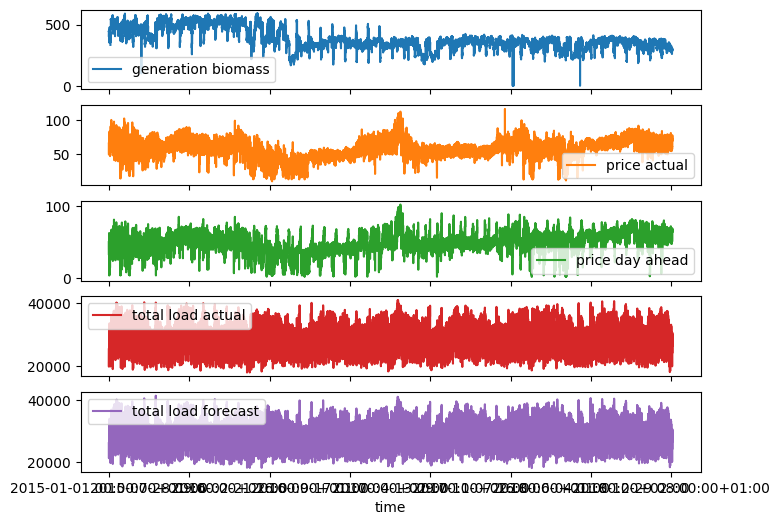

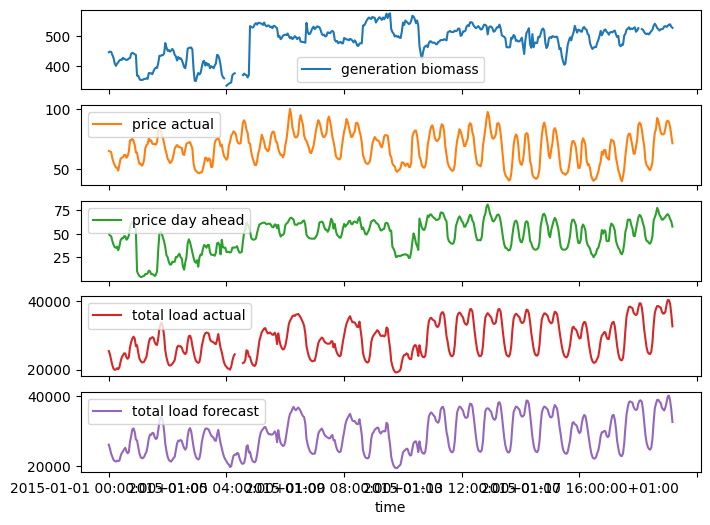

In [12]:
fig=plt.figure(figsize=(10,20))
date_time = df['time']
plot_cols = ['generation biomass', 'price actual', 'price day ahead', 'total load actual', 'total load forecast']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True);

## ✅ **Tâche 4a: Évaluer les modèles de baseline**

Nous utiliserons le dictionnaire suivant pour définir les configurations de la fonction `hyperparameter_sweep()` pour différents modèles et observer leurs performances.

In [13]:
sweep_cfg = {
    'model_name': 'baseline-mean',
    "target": 'price actual',
    "col_offset": 1,
    "hp_name": 'window_size',
    "hp_values": [8,16,32,64],
    "metric": 'RMSE',
    "epochs": 50,
    "lr": 1e-3,
    "batch_size": 128,
    "test_bs": 256,
}

[1 point]

### 📌 Q4.1 Modifiez le dictionnaire `sweep_cfg` pour obtenir les résultats du modèle de baseline de la moyenne.


In [43]:
## Student TODO ##
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

sweep_cfg['model_name'] = 'baseline-mean'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
Best Mean Squared Error:  0.6264021
Best Window Size:  8


[1 point]

### 📌 Q4.2 Modifiez le dictionnaire `sweep_cfg` pour obtenir les résultats du modèle de baseline de la dernière valeur (last).


In [44]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-last'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
Best Mean Squared Error:  1.3091487
Best Window Size:  16


## ✅ **Tâche 4b: Entrainer le modèle AR linéaire et régler la taille de la fenêtre**

[2 points]

### 📌 Q4.3 Modifiez le dictionnaire sweep_cfg pour obtenir les résultats du modèle AR linéaire et régler pour le window_size optimal.

In [45]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-linear'
ARL_best_score, ARL_best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
Best Mean Squared Error:  3.1639423525575694e-08
Best Window Size:  8


## ✅ **Tâche 4c: Entrainer le modèle AR MLP et ajuster la taille de la fenêtre**

[2 points]

### 📌 Q4.4 Modifiez le dictionnaire sweep_cfg pour obtenir les résultats du modèle AR MP et régler pour le window_size optimal.

In [46]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-mlp'
sweep_cfg['mlp_dim'] = 10
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
Best Mean Squared Error:  0.0009583880892023444
Best Window Size:  8


## ✅ **Tâche 4d: Visualiser les prédictions**

[3 points]

### 📌 Q4.5 Générez un graphique pour comparer visuellement les séries temporelles de l'ensemble de test prédites par le meilleur modèle et les séries temporelles réelles.

(35064,) 8.355258e-08 1.0
219/219 [==============================] - 1s 2ms/step


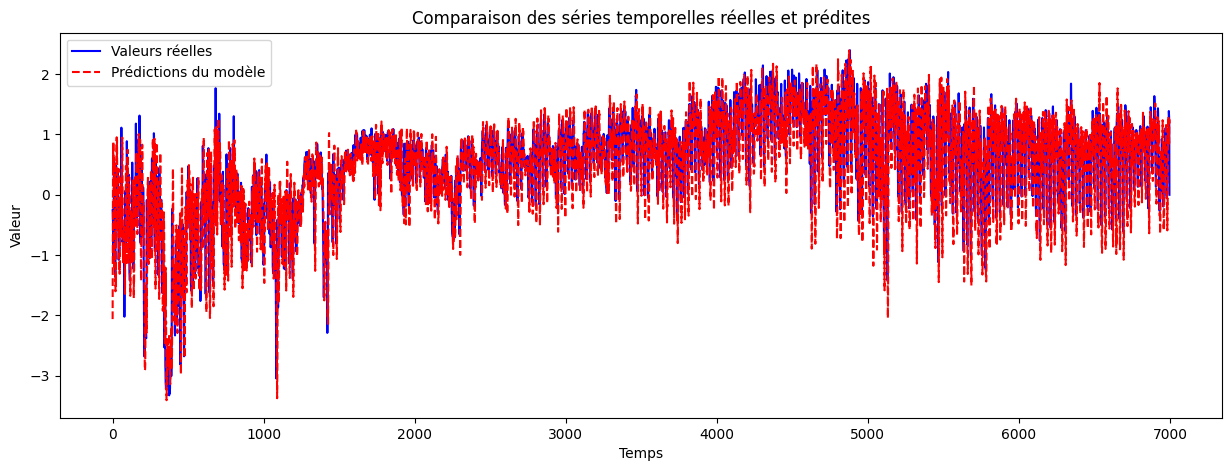

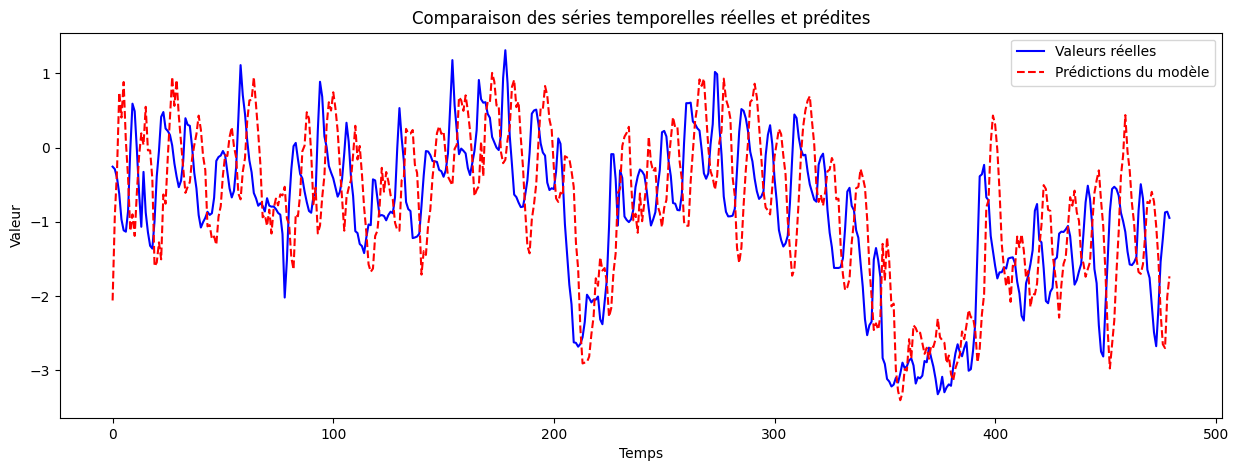

In [42]:
# Student TODO START
window_size = 16

# Prétraiter le jeu de données pour la meilleure taille de fenêtre
data = preprocess_dataset(df, sweep_cfg['target'], lookback=window_size)

# Définir la taille de la fenêtre dans sweep_cfg
sweep_cfg['window_size'] = window_size

# Préparer les générateurs de données
_, _, test_generator = prepare_dataloaders(data, sweep_cfg)

# Générer X_test et y_test en utilisant le test_generator
X_test = []
y_test = []
for batch in test_generator:
    X, y = batch
    X_test.append(X)
    y_test.append(y)

# Concaténer les résultats si X_test et y_test sont des listes de batchs
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)



# Charger le meilleur modèle ar-linear avec les paramètres optimisés
best_model = ar_linear({'window_size': ARL_best_hp})
best_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Générez des prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Créer le graphique pour comparer les valeurs réelles et les prédictions
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Valeurs réelles', color='blue')
plt.plot(y_pred, label='Prédictions du modèle', color='red', linestyle='--')
plt.title('Comparaison des séries temporelles réelles et prédites')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()
# Créer le graphique pour comparer les valeurs réelles et les prédictions sur les 480 premières valeurs
plt.figure(figsize=(15, 5))
plt.plot(y_test[:480], label='Valeurs réelles', color='blue')
plt.plot(y_pred[:480], label='Prédictions du modèle', color='red', linestyle='--')
plt.title('Comparaison des séries temporelles réelles et prédites')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()
# Student TODO END

[3 points]

### 📌 Q4.6 : Quel modèle fonctionne le mieux? Lequel est le pire? Donnez une explication de vos propres mots sur pourquoi vous observez cela.


<STUDENT_TODO_START>

\#STUDENT TODO

Parmi les modèles testés, le ar-linear a le plus faible MSE, ce qui indique qu'il est le plus performant pour notre série temporelle. Cela suggère que les relations linéaires entre les points de données consécutifs sont fortes et que le modèle peut bien les capturer. Le modèle ar-mlp, avec un MSE légèrement supérieur, est également assez bon, ce qui pourrait indiquer que des non-linéarités existent mais ne sont pas aussi prédominantes.

En revanche, le modèle baseline-last présente le plus haut MSE, ce qui implique qu'il ne parvient pas à suivre les tendances ou les motifs de la série temporelle, probablement parce que celle-ci n'est pas stationnaire et que la valeur future ne ressemble pas simplement à la dernière observation. Le baseline-mean est un peu meilleur, mais reste loin derrière les modèles autorégressifs, ce qui montre que prendre juste la moyenne des observations passées n'est pas suffisant pour prédire avec précision.

<STUDENT_TODO_END>

#Jeu de données 2 : Cours boursiers

Ce jeu de données se compose d'attributs variés liés aux cours boursiers de diverses sociétés cotées en bourse.

## Charger les données et les visualiser


In [47]:
dataset = load_dataset("edarchimbaud/timeseries-1m-stocks")
df = dataset['train'].to_pandas()
df

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3283794 [00:00<?, ? examples/s]

,symbol,datetime,open,high,low,close,volume
0,A,2023-05-26 15:30:00,120.070000,120.195000,119.830002,120.195000,23427.0
1,A,2023-05-26 15:31:00,120.349998,120.720001,120.190002,120.720001,2715.0
2,A,2023-05-26 15:32:00,120.480003,120.480003,120.084999,120.084999,2683.0
3,A,2023-05-26 15:33:00,120.199997,120.449997,120.160004,120.180000,3832.0
4,A,2023-05-26 15:34:00,120.239998,120.309998,120.239998,120.309998,359.0
...,...,...,...,...,...,...,...
3283789,ZTS,2023-11-20 20:56:00,175.910004,176.029999,175.910004,176.020004,9226.0
3283790,ZTS,2023-11-20 20:57:00,176.029999,176.130005,176.000000,176.039993,18115.0
3283791,ZTS,2023-11-20 20:58:00,176.070007,176.179993,176.070007,176.160004,13280.0
3283792,ZTS,2023-11-20 20:59:00,176.145004,176.190002,176.000000,176.080002,48042.0


Concentrons-nous sur les cours boursiers d'Apple Inc., représentés par le code 'AAPL'.

In [48]:
df.index = df['symbol']
del df['symbol']
df.xs('AAPL')

,datetime,open,high,low,close,volume
symbol,,,,,,
AAPL,2023-05-26 15:30:00,173.320007,173.600006,173.110001,173.320007,1249137.0
AAPL,2023-05-26 15:31:00,173.320007,173.740005,173.270004,173.639999,258116.0
AAPL,2023-05-26 15:32:00,173.619995,173.719894,173.470001,173.660004,195140.0
AAPL,2023-05-26 15:33:00,173.660004,173.830002,173.610001,173.829193,258145.0
AAPL,2023-05-26 15:34:00,173.824997,173.869995,173.498993,173.500000,155033.0
...,...,...,...,...,...,...
AAPL,2023-11-20 20:56:00,191.279999,191.354996,191.240005,191.309998,221349.0
AAPL,2023-11-20 20:57:00,191.309998,191.419998,191.300003,191.365005,269412.0
AAPL,2023-11-20 20:58:00,191.369995,191.380005,191.330002,191.350006,307116.0


Visualisons certaines caractéristiques.



<Figure size 1000x2000 with 0 Axes>

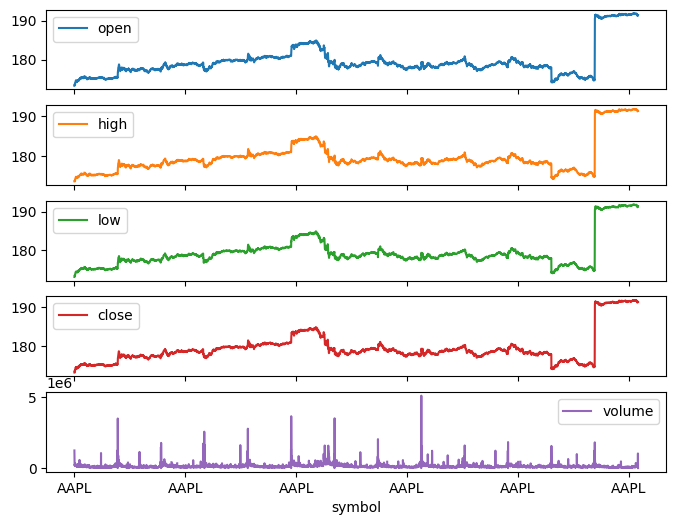

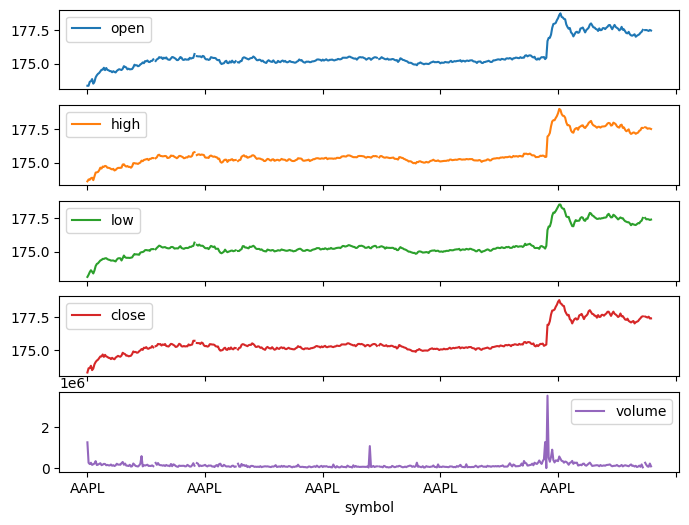

In [49]:
fig=plt.figure(figsize=(10,20))
date_time = df.xs('AAPL')['datetime']
plot_cols = ['open', 'high', 'low', 'close', 'volume'] # Use actual features
plot_features = df.xs('AAPL')[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df.xs('AAPL')[plot_cols][:480]
# plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True);

## ✅ **Tâche 5a: Évaluer les modèles de baseline**

Nous utiliserons le dictionnaire suivant pour définir les configurations de la fonction `hyperparameter_sweep()` pour différents modèles et observer leurs performances.

In [50]:
sweep_cfg = {
    'model_name': 'baseline-mean',
    "target": 'price actual',
    "col_offset": 1,
    "hp_name": 'window_size',
    "hp_values": [8,16,32,64],
    "metric": 'RMSE',
    "epochs": 50,
    "lr": 1e-3,
    "batch_size": 128,
    "test_bs": 256,
}

#Utiliser uniquement les prix des actions d'Apple Inc. pour les tâches restantes.
df = df.xs('AAPL')

[1 point]

### 📌 Q5.1 Modifiez le dictionnaire `sweep_cfg` pour obtenir les résultats du modèle de baseline de la moyenne.


In [52]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-mean'
sweep_cfg['target'] = 'close'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
Best Mean Squared Error:  1.1757383
Best Window Size:  8


[1 point]

### 📌 Q5.2 Modifiez le dictionnaire `sweep_cfg` pour obtenir les résultats du modèle de baseline de la dernière valeur (last).


In [53]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-last'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
Best Mean Squared Error:  1.189271
Best Window Size:  8


## ✅ **Tâche 5b: Entrainer le modèle AR linéaire et régler la taille de la fenêtre**

[2 points]

### 📌 Q5.3 Modifiez le dictionnaire sweep_cfg pour obtenir les résultats du modèle AR linéaire et régler pour le window_size optimal.

In [56]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-linear'
ARL_best_score, ARL_best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
Best Mean Squared Error:  0.05499443784356117
Best Window Size:  64


## ✅ **Tâche 5c: Entrainer le modèle AR MLP et ajuster la taille de la fenêtre**

[2 points]

### 📌 Q5.4 Modifiez le dictionnaire sweep_cfg pour obtenir les résultats du modèle AR MP et régler pour le window_size optimal.

In [57]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-mlp'
sweep_cfg['mlp_dim'] = 10
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
Best Mean Squared Error:  0.0005616986309178174
Best Window Size:  8


## ✅ **Tâche 5d: Visualiser les prédictions**

[3 points]

### 📌 Q5.5 Générez un graphique pour comparer visuellement les séries temporelles de l'ensemble de test prédites par le meilleur modèle et les séries temporelles réelles.

(5083,) -1.3238493e-06 1.0
32/32 [==============================] - 0s 1ms/step


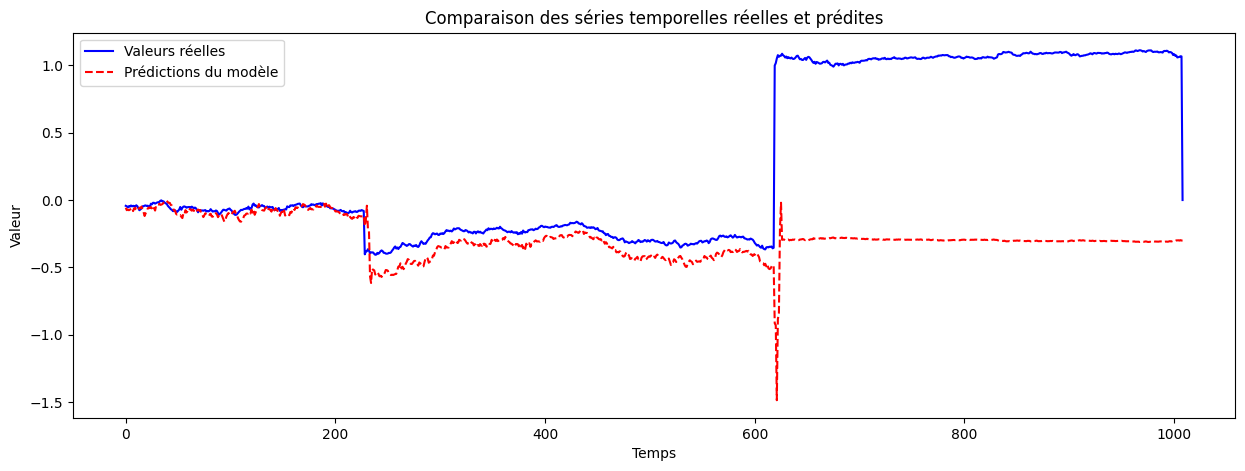

In [59]:
# Student TODO START
# Student TODO START
window_size = 8
mlp_dim = 10

# Prétraiter le jeu de données pour la meilleure taille de fenêtre
data = preprocess_dataset(df, sweep_cfg['target'], lookback=window_size)

# Définir la taille de la fenêtre dans sweep_cfg
sweep_cfg['window_size'] = window_size

# Préparer les générateurs de données
_, _, test_generator = prepare_dataloaders(data, sweep_cfg)

# Générer X_test et y_test en utilisant le test_generator
X_test = []
y_test = []
for batch in test_generator:
    X, y = batch
    X_test.append(X)
    y_test.append(y)

# Concaténer les résultats si X_test et y_test sont des listes de batchs
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Charger le meilleur modèle ar-mlp avec les paramètres optimisés
best_model = ar_mlp({'window_size': best_hp, 'mlp_dim': 10})
best_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Générez des prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Créer le graphique pour comparer les valeurs réelles et les prédictions
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Valeurs réelles', color='blue')
plt.plot(y_pred, label='Prédictions du modèle', color='red', linestyle='--')
plt.title('Comparaison des séries temporelles réelles et prédites')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

# Student TODO END

[3 points]

### 📌 Q5.6 : Quel modèle fonctionne le mieux? Lequel est le pire? Donnez une explication de vos propres mots sur pourquoi vous observez cela.


<STUDENT_TODO_START>

\#STUDENT TODO

Le modèle ar_mlp est un modèle de réseau de neurones qui peut capturer des relations non linéaires complexes entre les points de données, ce qui est  bénéfique dans notre séries temporelles financières puisqu'ils peuvent mieux saisir les motifs sous-jacents et les dynamiques de marché.

Le modèle ar-linear, bien que performant, n'est pas aussi efficace pour saisir ces non-linéarités, ce qui pourrait expliquer pourquoi il a un MSE plus élevé que le modèle ar_mlp.

Les modèles de base baseline-mean et baseline-last sont  moins performants car ils sont très simplistes. Le baseline-mean prédit simplement la moyenne des observations passées, tandis que le baseline-last prédit que la prochaine valeur sera identique à la dernière observation. Ces modèles ne tiennent pas compte des structures plus complexes des données.


<STUDENT_TODO_END>